In [1]:
import xarray as xr
from glob import glob
from datetime import datetime
import yaml
import sys
sys.path.append('../../')

import plotting

from conf.global_settings import OUTPUT_DIR
from utils.pipeline_utils.file_utils import get_date
from transformations.grid_transformation import Transformation

In [2]:
ds_name = "G02202_V4"
hemisphere = 'nh'
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [3]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.nc*')
if hemisphere:
    ds_granules = [g for g in ds_granules if hemisphere in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/G02202_V4/harvested_granules/1980/seaice_conc_daily_nh_19800731_n07_v04r00.nc


In [4]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = xr.open_dataset(sample_granule_path)
ds

<xarray.Dataset>
Dimensions:                         (tdim: 1, y: 448, x: 304)
Coordinates:
    time                            (tdim) datetime64[ns] ...
    xgrid                           (x) float32 ...
    ygrid                           (y) float32 ...
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc                 (tdim, y, x) float32 ...
    melt_onset_day_cdr_seaice_conc  (tdim, y, x) float32 ...
    nsidc_bt_seaice_conc            (tdim, y, x) float32 ...
    nsidc_nt_seaice_conc            (tdim, y, x) float32 ...
    projection                      |S1 ...
    qa_of_cdr_seaice_conc           (tdim, y, x) float32 ...
    spatial_interpolation_flag      (tdim, y, x) float32 ...
    stdev_of_cdr_seaice_conc        (tdim, y, x) float32 ...
    temporal_interpolation_flag     (tdim, y, x) float32 ...
Attributes: (12/40)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    source:                    Generated from NSIDC0007
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-21T17:14:59Z
    time_coverage_start:       1980-07-31T00:00:00Z
    time_coverage_end:         1980-07-31T23:59:59Z

# Load grid

In [5]:
grids = glob(f'grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/TPOSE.nc', 'grids/polar_stereo_n_25km.nc']"

In [6]:
grid_ds = xr.open_dataset(grids[1])
grid_ds

<xarray.Dataset>
Dimensions:                (tile: 13, j: 90, i: 90)
Coordinates:
  * tile                   (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                      (j) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i                      (i) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Data variables:
    XC                     (tile, j, i) float32 ...
    YC                     (tile, j, i) float32 ...
    effective_grid_radius  (tile, j, i) float32 ...
Attributes:
    name:                  ECCO_llc90
    type:                  llc
    geospatial_lat_min:    -89.873055
    geospatial_lat_max:    89.739395
    geospatial_lon_min:    -179.98895
    geospatial_lon_max:    179.98691
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [7]:
T = Transformation(config, sample_granule_path, granule_date)

# Make mapping factors

In [8]:
factors = T.make_factors(grid_ds)

# Transformation

In [9]:
field_ds_list = T.transform(grid_ds, factors, ds)

In [10]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                                     (time: 1, tile: 13, j: 90,
                                                 i: 90, nv: 2)
Coordinates:
  * time                                        (time) datetime64[ns] 1980-07...
  * tile                                        (tile) int16 0 1 2 ... 10 11 12
  * j                                           (j) int16 0 1 2 3 ... 87 88 89
  * i                                           (i) int16 0 1 2 3 ... 87 88 89
    XC                                          (tile, j, i) float32 -111.6 ....
    YC                                          (tile, j, i) float32 -88.24 ....
    time_bnds                                   (time, nv) datetime64[ns] 198...
Dimensions without coordinates: nv
Data variables:
    cdr_seaice_conc_interpolated_to_ECCO_llc90  (time, tile, j, i) float64 9....
Attributes:
    interpolated_grid:            ECCO_llc90
    model_grid_type:              llc
    original_dataset_title:       NOAA/NSIDC Climate Data Record of Passive M...
    original_dataset_short_name:  G02202_V4
    original_dataset_url:         https://nsidc.org/data/G02202/versions/4
    original_dataset_reference:   https://nsidc.org/sites/nsidc.org/files/tec...
    original_dataset_doi:         10.7265/efmz-2t65
    interpolated_grid_id:         ECCO_llc90
    transformation_version:       1.19
    notes:                        All values flagged as pole_hole, lakes, coa...

# Visualization

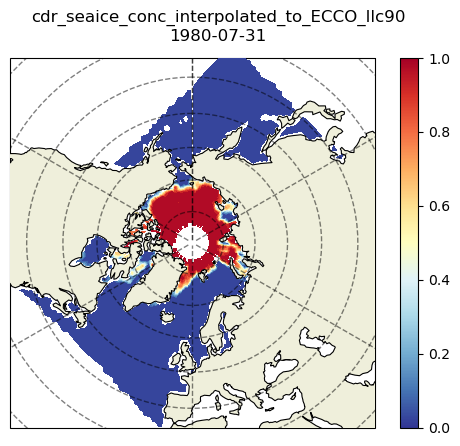

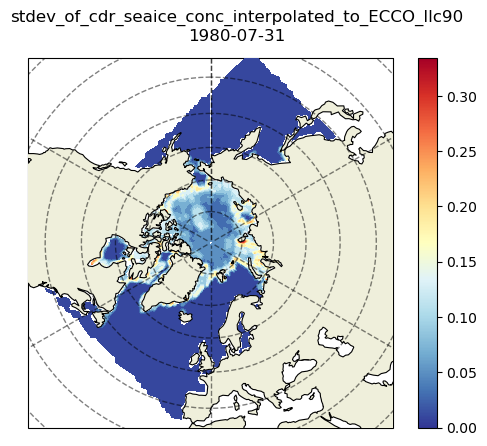

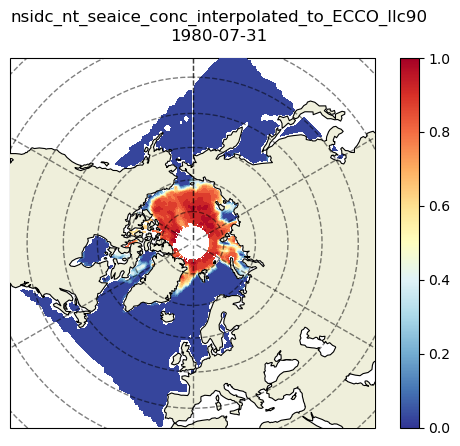

In [11]:
for field_ds in field_ds_list:
    plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]], 'nh')
